In [350]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from scipy.io import loadmat

In [351]:
# train_x = torch.linspace(0, 1, 15)
# train_y = torch.sin(train_x * (2 * math.pi))

#First load data from xarray
data = loadmat('/scratch/ns5264/bml-ocean/myjupyter/datasets/airlinedata.mat')

x_train = torch.FloatTensor(data['xtrain']).squeeze()
y_train = torch.FloatTensor(data['ytrain'].astype(int)).squeeze()

x_test = torch.FloatTensor(data['xtest']).squeeze()
y_test = torch.FloatTensor(data['ytest'].astype(int)).squeeze()

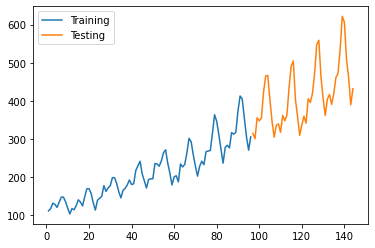

In [352]:
# Graph Our training and testing points
train_plt = plt.plot(x_train, y_train, label="Training")
test_plt = plt.plot(x_test, y_test, label="Testing")
plt.legend(loc="upper left")
plt.show()

In [353]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(SpectralMixtureGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #changes num mixtures
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=15, mixture_lengthscale=1)
        #changed to initialize_from_data_empspect from initialize_from_data
        self.covar_module.initialize_from_data_empspect(x_train, y_train)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(x_train, y_train, likelihood)

In [354]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

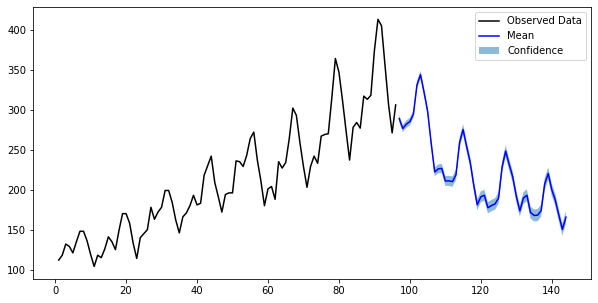

In [355]:
# test_x = torch.linspace(0, 5, 51)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_pred = likelihood(model(x_test))

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k')
    # Plot predictive means as blue line
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])